In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import torchvision.utils as vutils
from torch.utils.data import WeightedRandomSampler, DataLoader, Dataset
import time
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd

import seaborn as sns

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('running on:', device)

running on: cuda:0


In [3]:
SOURCE_IMG_SIZE = 48
IMG_SIZE = 96

CLASSES = ['neutral', 'happy', 'surprised', 'sad', 'angry'] #, 'disgusted', 'afraid'
NUM_CLASSES = len(CLASSES)

## Pre-processing

In [4]:
df_fer = pd.read_csv('../data/fer2013.csv').iloc[:, 1:]
df_ferplus = pd.read_csv('../data/ferplus2013.csv').iloc[:, [2, 3, 4, 5, 6]]
df = df_fer.join(df_ferplus)
# df.head(15)

df['emotion'] = df.iloc[:, 2:].idxmax(axis=1).tolist()
df = df.replace(dict(zip(pd.Series(CLASSES),pd.Series(CLASSES).index)))
# df.head(15)

print('number of images:', df.shape[0])
df = df[(df.iloc[:, 2:-1].max(axis=1) > 5)]
print('after removing images with unknown/unsure classification:', df.shape[0])
# df.head(15)

df = df.iloc[:, [0, 1, -1]]
# df.head(15)

number of images: 35887
after removing images with unknown/unsure classification: 26811


In [5]:
# ---- Normal Dataset ----
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.545), (0.245)),
])

images_np = np.array(df['pixels'])
label_np = np.array(df['emotion'])

images = []
labels = []

for i in range(df.shape[0]):
    b = bytes(int(p) for p in images_np[i].split())
    img = Image.frombuffer('L', (SOURCE_IMG_SIZE, SOURCE_IMG_SIZE), b)
    images.append(transform(img))
    labels.append(label_np[i])

In [6]:
label_counts = [0]*NUM_CLASSES

for i in range(len(labels)):
    label_counts[labels[i]] += 1

print('\033[4m{: <15} {: >10}\033[0m'.format('class', '#images'))
for i in range(NUM_CLASSES):
    print('{: <15} {: >10}'.format(CLASSES[i], label_counts[i]))

class              #images
neutral               9494
happy                 8802
surprised             3461
sad                   2958
angry                 2096


In [7]:
train_split_pct = 0.8
train_len = int(len(labels) * train_split_pct)

train_images = images[:train_len]
train_labels = labels[:train_len]
test_images = images[train_len:]
test_labels = labels[train_len:]

print(f'train length: {len(train_labels)} ({len(train_labels)*100/len(labels):.1f}%)')
print(f'test length: {len(test_labels)} ({len(test_labels)*100/len(labels):.1f}%)')

train length: 21448 (80.0%)
test length: 5363 (20.0%)


In [8]:
BATCH_SIZE = 32

class CustomDataset(Dataset):
    
    def __init__(self, images, labels):      
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]


train_dataset = CustomDataset(train_images, train_labels)
test_dataset = CustomDataset(test_images, test_labels)


def get_loader(dataset):
    print('get_loader():')

    label_counts = [0]*NUM_CLASSES
    for i in range(len(dataset.labels)):
        label_counts[dataset.labels[i]] += 1

    class_weights = pow(np.array(label_counts) / sum(label_counts), -1)
    print('  class weights:', class_weights.round(3), '\n')

    sample_weights = [0]*len(dataset)
    for idx, (image, label) in enumerate(dataset):
        sample_weights[idx] = class_weights[label]

    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    return DataLoader(dataset, BATCH_SIZE, sampler=sampler, shuffle=False)


train_loader = get_loader(train_dataset)
test_loader = get_loader(test_dataset)

get_loader():
  class weights: [ 2.848  3.015  7.771  8.963 12.991] 

get_loader():
  class weights: [ 2.732  3.175  7.65   9.492 12.052] 



-----
# AlexNet Model

In [9]:
# Batch size during training, remember to change the global one as well
batch_size = BATCH_SIZE

# Number of training epochs
num_epochs = 15

# Learning rate for optimizers
lr = 0.01

In [10]:
# Function for displaying predictions for a few images, in this case 6.
#print(test_set[0])

class_names = CLASSES
print(class_names)

def visualize_expression_model(model, num_images=4):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                plt.imshow(inputs.cpu().data[j].permute(1, 2, 0), cmap="gray")

                if images_so_far == num_images:
                    return

['neutral', 'happy', 'surprised', 'sad', 'angry']


In [11]:
loss_train = []
accuracy_train = []

def train_expression_model(model, data, criterion, optimizer):
    since = time.time()
    best_acc = 0.0
    model.train()   # Set model to train mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in data:
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        # zero the parameter gradients, and use backpropagatation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    loss_train.append(epoch_loss)
    accuracy_train.append(epoch_acc)

    print('train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

In [12]:
loss_test = []
accuracy_test = []
y_actual = []
y_pred = []

def test_expression_model(model, data, criterion):
    model.eval()   # Set model to evaluate mode
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in data:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predy = model(inputs)

        y_actual.extend(labels.cpu())
        y_pred.extend(predy.argmax(1).cpu())
    
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects.double() / len(test_dataset)

    loss_test.append(epoch_loss)
    accuracy_test.append(epoch_acc)

    print('test Loss: {:.4f} Acc: {:.4f}'.format(
        epoch_loss, epoch_acc))

In [13]:
# This is a recreation of the AlexNet model, https://pytorch.org/vision/0.12/_modules/torchvision/models/alexnet.html

class Facial_Expression_Network(nn.Module):
    def __init__(self):
        super(Facial_Expression_Network, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, IMG_SIZE, kernel_size=(3,3), stride=(1, 1), padding=(2, 2)), 
            nn.ReLU(inplace=True), # Rectified Linear Unit activation function
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False), # pooling layer for reducing dimensions
            nn.Conv2d(IMG_SIZE, 192, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            nn.Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

        self.avgpool = nn.AdaptiveAvgPool2d(output_size=(6, 6)) # Applies a 2D adaptive average pooling over an input composed of several input planes.


        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False), # Dropout layer for setting 50% of the activations to 0, fording the network to not rely on any 1 node
            nn.Linear(in_features=9216, out_features=4096, bias=True), # Linear layer
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5, inplace=False),
            nn.Linear(in_features=4096, out_features=4096, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=5, bias=True),
        ) # ---- Change out_features if change in amount of classes ----


        self.softmax = nn.Softmax(dim=1) # last activation function for the network, normalizing the output
        self.softmax_result = 0 

    def forward(self, x, verbose=False):
        x = self.features(x)
        x = self.avgpool(x)

        # The data needs to be flattened after the AdaptiveAvgPool2d as its output is H x W
        # This is because the classifier's first layer is a Linear layer
        x = torch.flatten(x, 1)

        x = self.classifier(x) 
        self.softmax_result = self.softmax(x)
        return x

In [14]:
expression_model = Facial_Expression_Network().to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(expression_model.parameters(), lr=lr, momentum = 0.9) # So far, only 31.1% acc
#optimizer = torch.optim.Adam(expression_model.parameters(), lr=lr)

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.0001)

In [15]:
for epoch in range(1, (num_epochs+1)):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print()
    train_expression_model(expression_model, train_loader, loss_fn, optimizer)
    test_expression_model(expression_model, test_loader, loss_fn)
    scheduler.step

Epoch 1/15

train Loss: 0.0492 Acc: 0.2595
test Loss: 0.0469 Acc: 0.2993
Epoch 2/15

train Loss: 0.0428 Acc: 0.4081
test Loss: 0.0389 Acc: 0.4801
Epoch 3/15

train Loss: 0.0332 Acc: 0.5720
test Loss: 0.0276 Acc: 0.6552
Epoch 4/15

train Loss: 0.0256 Acc: 0.6818
test Loss: 0.0215 Acc: 0.7281
Epoch 5/15

train Loss: 0.0204 Acc: 0.7434
test Loss: 0.0218 Acc: 0.7306
Epoch 6/15

train Loss: 0.0172 Acc: 0.7895
test Loss: 0.0173 Acc: 0.8007
Epoch 7/15

train Loss: 0.0150 Acc: 0.8195
test Loss: 0.0195 Acc: 0.7701
Epoch 8/15

train Loss: 0.0126 Acc: 0.8465
test Loss: 0.0150 Acc: 0.8175
Epoch 9/15

train Loss: 0.0109 Acc: 0.8678
test Loss: 0.0151 Acc: 0.8212
Epoch 10/15

train Loss: 0.0091 Acc: 0.8923
test Loss: 0.0157 Acc: 0.8236
Epoch 11/15

train Loss: 0.0081 Acc: 0.9056
test Loss: 0.0157 Acc: 0.8244
Epoch 12/15

train Loss: 0.0074 Acc: 0.9110
test Loss: 0.0152 Acc: 0.8404
Epoch 13/15

train Loss: 0.0064 Acc: 0.9254
test Loss: 0.0152 Acc: 0.8307
Epoch 14/15

train Loss: 0.0058 Acc: 0.9291
tes

In [16]:
#torch.save(expression_model.state_dict(), "face_expression_model.pt")

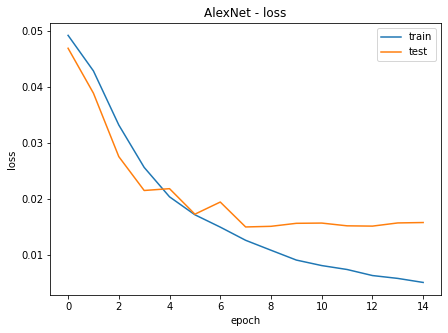

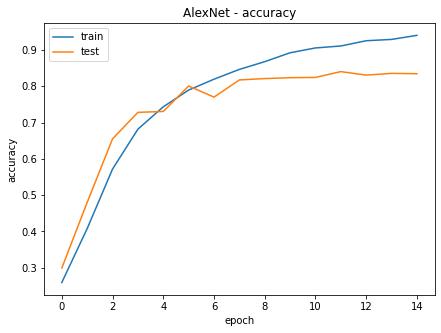

In [17]:
def plot_metric(train, test, metric, title):
    plt.figure(figsize = (7, 5))

    train = torch.tensor(train, device='cpu')
    test = torch.tensor(test, device='cpu')

    with torch.no_grad():
        plt.plot(range(len(train)), train, label = "train")
        plt.plot(range(len(test)), test, label = "test")
    plt.title(title)
    plt.xlabel('epoch')
    plt.ylabel(metric)
    plt.legend()

    # plt.savefig(f'{title}.png')
    plt.show()


plot_metric(loss_train, loss_test, 'loss', 'AlexNet - loss')
plot_metric(accuracy_train, accuracy_test, 'accuracy', 'AlexNet - accuracy')

Text(87.0, 0.5, 'Actual')

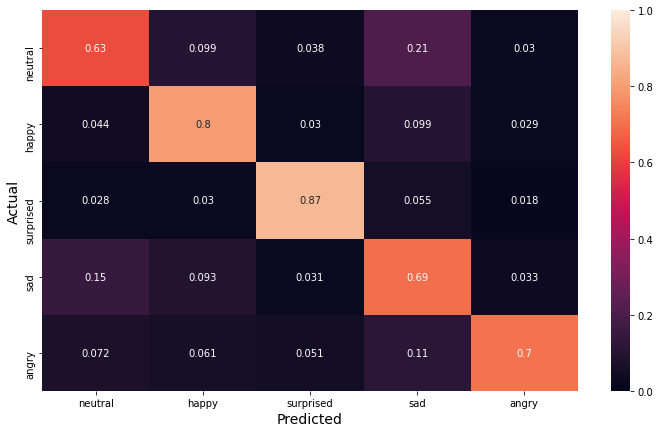

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


counts = np.array([(np.array(y_actual) == i).sum() for i in range(NUM_CLASSES)]).reshape(-1, 1)
cf_matrix = confusion_matrix(y_actual, y_pred)
cf_matrix_norm = cf_matrix / counts

df_cm = pd.DataFrame(cf_matrix_norm, index = CLASSES, columns = CLASSES)
plt.figure(figsize = (12,7))
s = sns.heatmap(df_cm, annot=True, cmap=sns.color_palette("rocket", as_cmap=True), vmin=0, vmax=1)
s.set_xlabel('Predicted', fontsize=14)
s.set_ylabel('Actual', fontsize=14)

# plt.savefig('confusion_matrix.png')

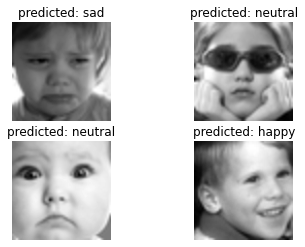

In [19]:
visualize_expression_model(expression_model)

##### End of AlexNet Model
-----